In [1]:
import torch
import torchvision

from dataclasses import dataclass
from lightning.fabric.utilities import AttributeDict
from tqdm import tqdm

import lightning as L
import matplotlib.pyplot as plt

from PIL import Image
from diffusers import DDPMScheduler
from datasets import load_dataset
from torchvision import transforms
from diffusers import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup

from TL.generation import Tempering

In [2]:
def save_images(images: torch.Tensor, filename: str):
    images = (images / 2 + 0.5).clamp(0, 1).squeeze()
    grid = torchvision.utils.make_grid(images, nrow=5)
    grid_np = (grid.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    grid_pil = Image.fromarray(grid_np)
    grid_pil.save(filename)

In [3]:
@dataclass
class Arguments:

    seed: int = 42
    num_nodes: int = 1
    strategy: str = "auto"
    precision: str = None

    image_size: int = 32

    train_batch_size: int = 16
    learning_rate: float = 1e-4
    lr_warmup_steps: int = 500

    T: int = 50
    num_epochs_per_timestep: int = 2
    burn_in_fraction: float = 0.8
    zeta: float = 4.0
    m: float = 0.5
    random_walk_step_size: float = 1e-6
    sample_prediction: bool = True

args = Arguments()

In [4]:
# set seed
L.seed_everything(args.seed)

# set fabric
fabric = L.Fabric(
    accelerator="auto", 
    devices="auto",
    num_nodes=args.num_nodes,
    strategy=args.strategy,
    precision=args.precision,
)

# launch fabric
fabric.launch()

Seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [5]:
# set dataset
train_dataset = load_dataset(
    "huggan/smithsonian_butterflies_subset", 
    split="train", 
    cache_dir="./cache"
)

# set transform
preprocess = transforms.Compose(
    [
        transforms.Resize((args.image_size, args.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

train_dataset.set_transform(transform)
num_training_samples = len(train_dataset)

# set dataloader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=args.train_batch_size, 
    shuffle=True,
    pin_memory=True,
)
num_training_batches = len(train_dataloader)

print ("Number of training batches:", num_training_batches)

Repo card metadata block was not found. Setting CardData to empty.


Number of training batches: 63


In [6]:
# set model
model = UNet2DModel(
    sample_size=args.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 32, 64, 64, 128, 128),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

num_trainable_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_trainable_params}")

Number of parameters: 7126275


In [7]:
# set noise scheduler
noise_scheduler = DDPMScheduler()
print ("Number of training timesteps:", noise_scheduler.config.num_train_timesteps)

Number of training timesteps: 1000


In [8]:
# set tempering learning
num_mc_steps = num_training_batches * args.num_epochs_per_timestep
tlmodel = Tempering(
    model=model,
    noise_scheduler=noise_scheduler,
    T=args.T,
    num_mc_steps=num_mc_steps,
    num_training_samples=num_training_samples,
    zeta=args.zeta,
    mc_subset_ratio=args.m,
    burn_in_fraction=args.burn_in_fraction,
    random_walk_step_size=args.random_walk_step_size,
    sample_prediction=args.sample_prediction,
)

print ("Number of MC steps:", tlmodel.num_mc_steps)
print ("Burn in steps:", tlmodel.burn_in_steps)
print ("Number of MC samples:", tlmodel.num_mc_samples)
print ("MC subset size:", tlmodel.mc_subset_size)

print ("Number of training samples:", num_training_samples)
print ("Zeta:", args.zeta)
print ("Random walk step size:", args.random_walk_step_size)

print ("timestep mapping:", tlmodel.timestep_schedule)

Number of MC steps: 126
Burn in steps: 100
Number of MC samples: 26
MC subset size: 13
Number of training samples: 1000
Zeta: 10.0
Random walk step size: 1e-06
timestep mapping: tensor([  0,  20,  40,  61,  81, 101, 122, 142, 163, 183, 203, 224, 244, 265,
        285, 305, 326, 346, 366, 387, 407, 428, 448, 468, 489, 509, 530, 550,
        570, 591, 611, 632, 652, 672, 693, 713, 733, 754, 774, 795, 815, 835,
        856, 876, 897, 917, 937, 958, 978, 999])


In [9]:
# set optimizer
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=args.learning_rate
)

# set lr scheduler
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps,
    num_training_steps=args.T*args.num_epochs_per_timestep*num_training_batches
)

In [10]:
# set up objects
tlmodel, optimizer = fabric.setup(tlmodel, optimizer)
train_dataloader = fabric.setup_dataloaders(train_dataloader)

In [11]:
# train
tlmodel.train()

progress_bar = tqdm(range(args.T), desc="Training timesteps")

for t in progress_bar:

    tlmodel.reset_sample_buffers()

    batch_idx = 0

    avg_train_loss_per_timestep = 0

    for epoch in range(args.num_epochs_per_timestep):

        for _, batch in enumerate(train_dataloader):

            optimizer.zero_grad()

            loss = tlmodel.training_step(batch, t)

            avg_train_loss_per_timestep += loss.item()

            fabric.backward(loss)

            tlmodel.on_before_optimizer_step(t)

            optimizer.step()

            lr_scheduler.step()

            tlmodel.on_train_batch_end(lr_scheduler.get_last_lr()[0], batch_idx)

            batch_idx += 1

    avg_train_loss_per_timestep /= (args.num_epochs_per_timestep * num_training_batches)
    progress_bar.set_postfix({'Avg train loss': f'{avg_train_loss_per_timestep:.4f}'})

    tlmodel.eval()
    images = tlmodel.generate_samples(args.train_batch_size, t)
    save_images(images, f"generated_samples/images_{t}.png")
    tlmodel.train()

state = AttributeDict(model=model)
fabric.save("output/model.pt", state)

Training timesteps:   0%|          | 0/50 [00:00<?, ?it/s]c:\Users\mingx\anaconda3\envs\mingxuan\Lib\site-packages\diffusers\models\attention_processor.py:2358: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  hidden_states = F.scaled_dot_product_attention(
Training timesteps:  94%|█████████▍| 47/50 [31:22<02:00, 40.04s/it, Avg train loss=0.7332]


KeyboardInterrupt: 

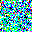

In [14]:
image = tlmodel.generate_samples(1)
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image = Image.fromarray(image)
image